In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import iqr
from numpy import histogram2d
from numpy import histogram
from sklearn.metrics import mutual_info_score
from matplotlib import pyplot as plt
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div
from persim import plot_diagrams 
from ripser import ripser, lower_star_img
from sklearn.cluster import KMeans
from scipy.stats.contingency import crosstab
import scanpy as sc

# Define mutual information function
def minfo(x, y):
    c = crosstab(np.squeeze(x),np.squeeze(y))
    mi=mutual_info_score(labels_true=None, labels_pred=None, contingency = c[1])
    return mi

def Generate_2dhist(x,y):
    bins_x = math.ceil(2*len(x)**(1/2)) # Rice rule
    bins_y = math.ceil(2*len(y)**(1/2))
    H, yedges, xedges = histogram2d(np.squeeze(x),np.squeeze(y), [bins_x,bins_y])
    return H, yedges, xedges

def Generate_1dhist(x):
    hist,bins=histogram(x,bins=math.ceil(2*len(x)**(1/2)),density=True) #rice rule
    return hist,bins

def Compute_entropy(x):
    data = histogram(x,bins=math.ceil(2*len(x)**(1/2)),density=True)[0]
    H = entropy(data)
    return H

def Compute_Wdistance(x,y):
    x=Generate_1dhist(x)[0]
    y=Generate_1dhist(y)[0]
    return wasserstein_distance(x,y)

def Compute_Jdistance(x,y):
    x=Generate_1dhist(x)[0]
    y=Generate_1dhist(y)[0]    
    return jensenshannon(x,y)

In [5]:
import pandas as pd
## tell pandas to make a new DataFrame with the contents of `brain_counts.csv`. This might take a minute.
count_dataframe = pd.read_csv("ClusterCells_GE_UMAP_1D/CellSorted_SRR12615659_GE_matrix_filtered.csv", # where to find the data
                              index_col=0).T # use the first column to label the rows (the 'index')
metadata_dataframe = pd.read_csv("ClusterCells_GE_UMAP_1D/SRR12615659_cluster_sample.csv", # where to find the data
                              index_col=1)
## print the first 2 rows of our dataframe
#print(count_dataframe.head(2)) 

In [6]:
import scanpy as sc
adata = sc.AnnData(X = count_dataframe, obs = metadata_dataframe)
print(adata)

AnnData object with n_obs × n_vars = 826 × 4674
    obs: 'Cell_Index', 'Cell_Type', 'Cell_Marker', 'Cell_Name'


In [10]:
adata.write('mymethod/cells_raw.h5ad')

# Normalization & PCA 

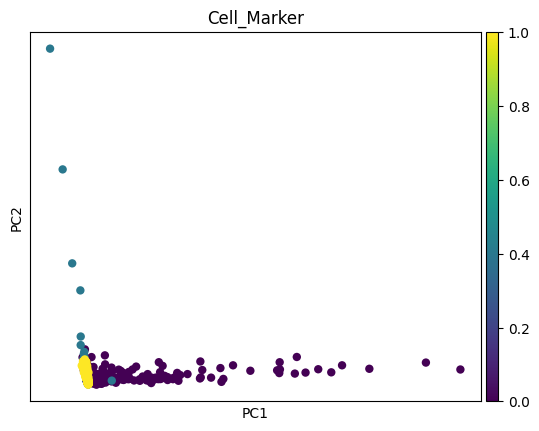

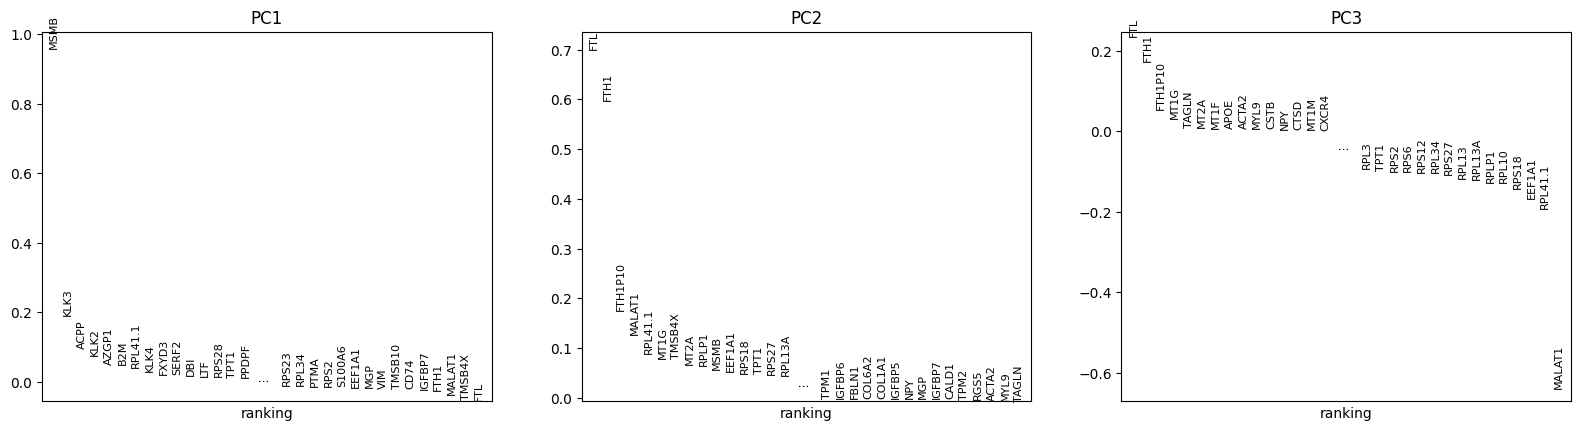

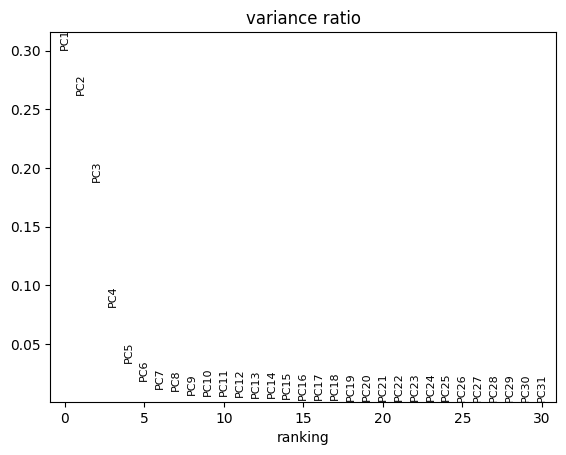

In [12]:
sc.pp.pca(adata)
sc.pl.pca_overview(adata, color='Cell_Marker')

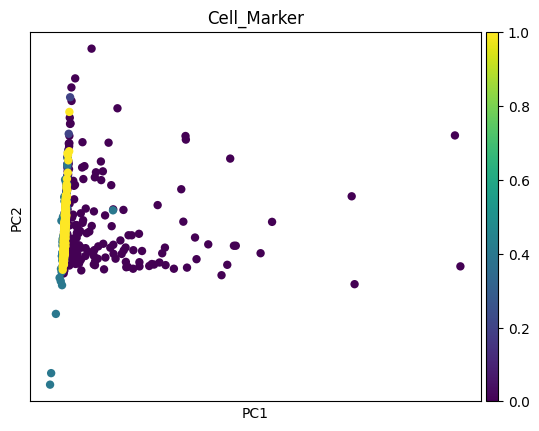

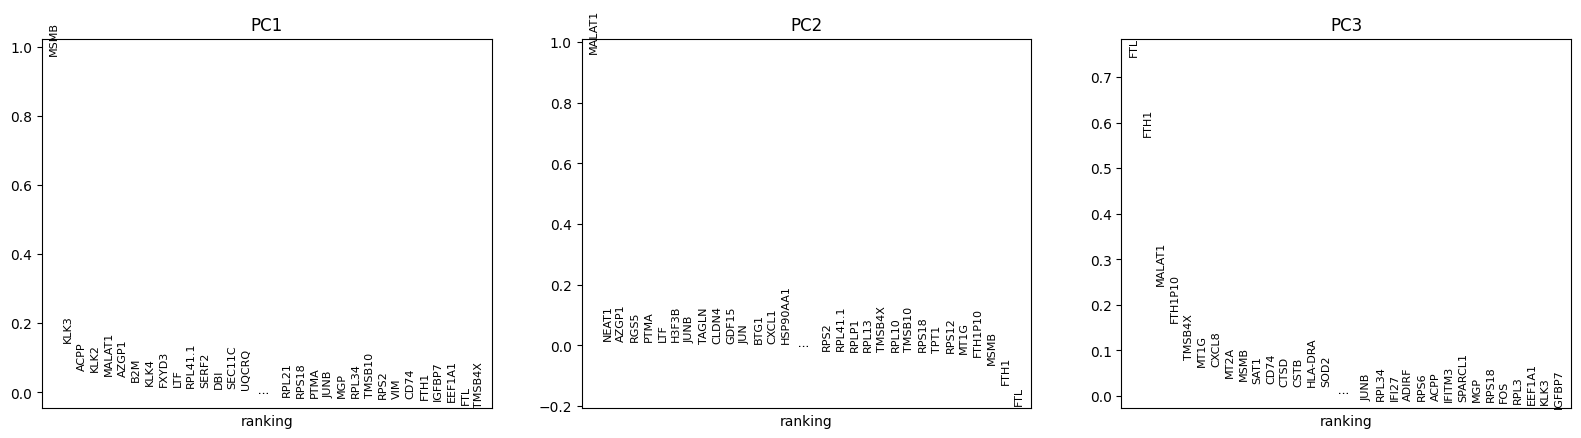

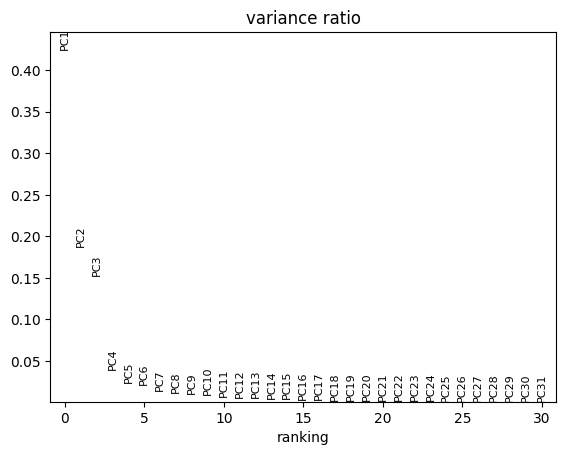

In [14]:
adata_cpm = adata.copy() # make a copy so we can compare results
adata_cpm.raw = adata_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_total(adata_cpm, target_sum=1e6, exclude_highly_expressed=True) # normalize
sc.pp.pca(adata_cpm) # run pca
sc.pl.pca_overview(adata_cpm, color='Cell_Marker') # plot pca

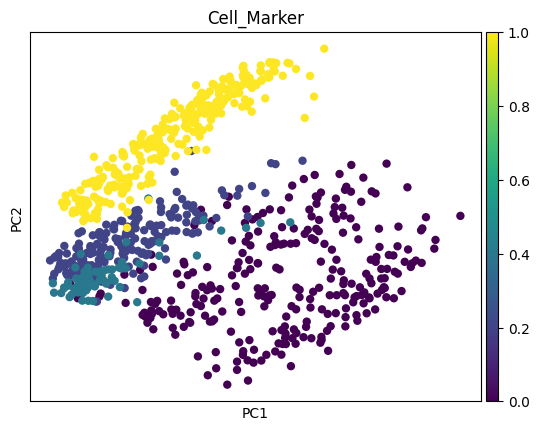

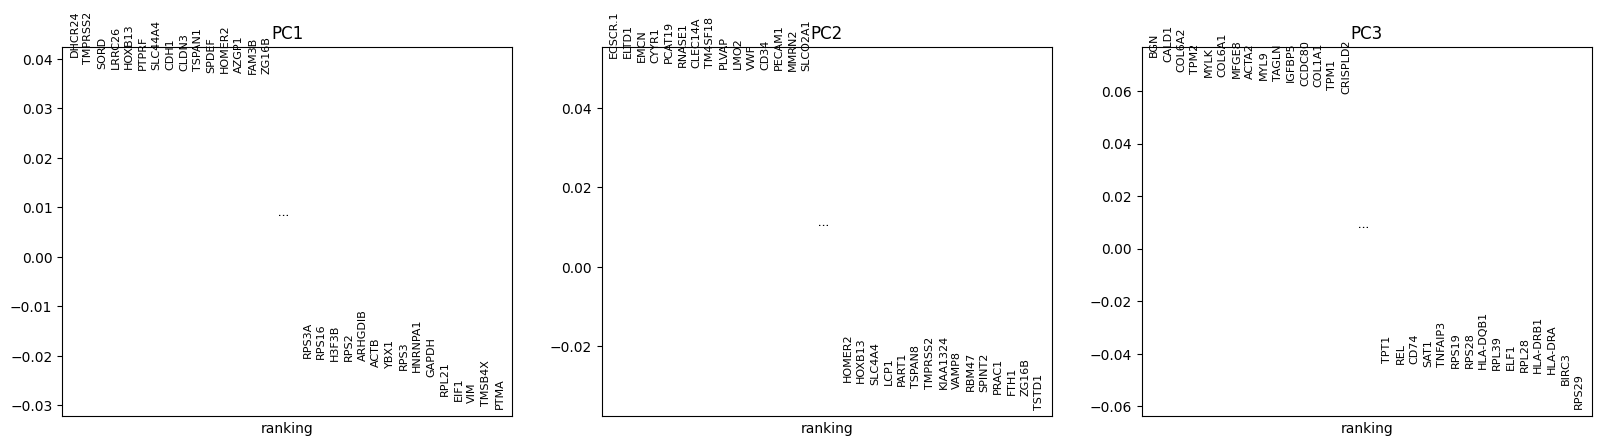

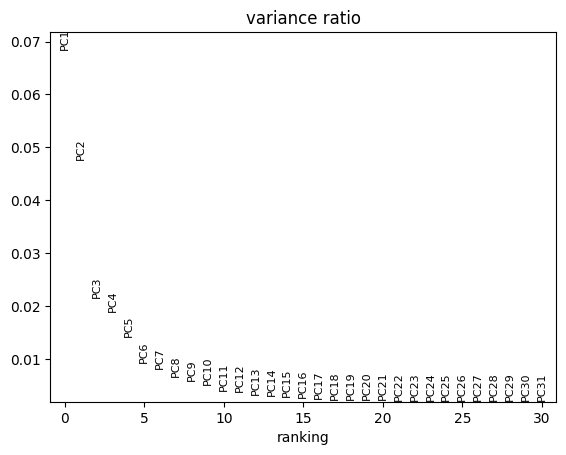

In [15]:
sc.pp.log1p(adata_cpm)
sc.pp.scale(adata_cpm)
sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm, color='Cell_Marker')

In [16]:
adata_cpm.write('mymethod/cells_normalized.h5ad')

# Dimensionality reduction  (non-information based method)

In [18]:
adata = sc.read('mymethod/cells_normalized.h5ad')

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


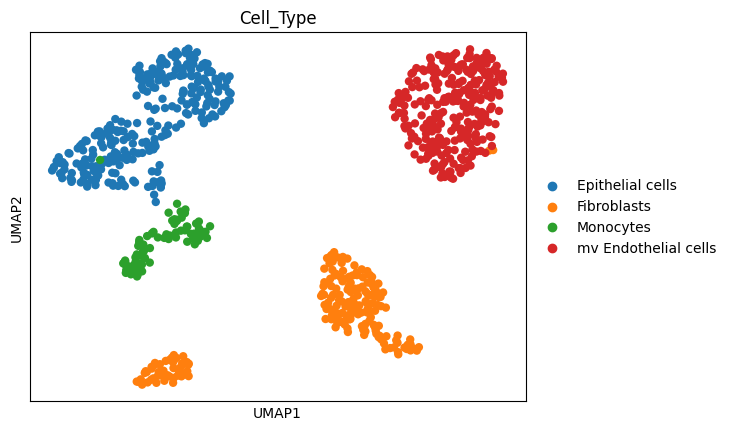

In [19]:
#UMAP
sc.pp.neighbors(adata) # UMAP is based on the neighbor graph; we'll compute this first
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)
sc.pl.umap(adata, color='Cell_Type')

In [20]:
adata.write('mymethod/cells_embeddings.h5ad')

# Clustering (non- information based method)

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
%matplotlib inline

adata = sc.read('mymethod/cells_embeddings.h5ad')

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


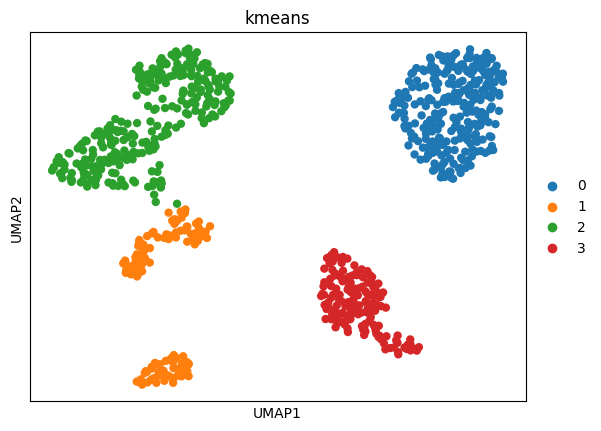

In [29]:
umap_coordinates = adata.obsm['X_umap'] # extract the UMAP coordinates for each cell
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results

In [30]:
#evaluating clustering
rand_index = adjusted_rand_score(labels_true = adata.obs['Cell_Type'], labels_pred = adata.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.91


In [31]:
adata.write('mymethod/cells_clusters.h5ad')

## Dimensionality reduction (Information based method)

In [32]:
adata = sc.read('mymethod/cells_normalized.h5ad')
#Build MI matrix
batch_size_features= adata.X.shape[0]
#MI_matrix = np.zeros((batch_size_features,batch_size_features)) #mutual information matrix
Mw_matrix = np.zeros((batch_size_features,batch_size_features)) #w distance matrix
Mj_matrix = np.zeros((batch_size_features,batch_size_features)) #Jensen-Shannon matrix
Hk= {}

for col_i in range(0,batch_size_features):
    #Hk.update({df.columns[col_i]:{"Entropy":Compute_entropy(df.iloc[:,col_i]),
     #                             "Histogram":Generate_1dhist(df.iloc[:,col_i])}})
    for col_j in range(col_i,batch_size_features):
        #MI_matrix[col_i,col_j] = minfo(df.iloc[:,col_i],df.iloc[:,col_j])
        Mw_matrix[col_i,col_j] = wasserstein_distance(adata.X[col_i,:]
                                                      ,adata.X[col_j,:])
        Mj_matrix[col_i,col_j] = jensenshannon(adata.X[col_i,:],
                                               adata.X[col_j,:])

#MI_matrix= MI_matrix+MI_matrix.T-np.diag(np.diag(MI_matrix))
Mw_matrix= Mw_matrix+Mw_matrix.T-np.diag(np.diag(Mw_matrix))
Mj_matrix= Mj_matrix+Mj_matrix.T-np.diag(np.diag(Mj_matrix))

/tmp/ipykernel_82346/3777061143.py:21: RuntimeWarning: invalid value encountered in subtract
  Mj_matrix= Mj_matrix+Mj_matrix.T-np.diag(np.diag(Mj_matrix))


In [34]:
np.savetxt("mymethod/Mw_matrix.csv", Mw_matrix, delimiter=",")
np.savetxt("mymethod/Mj_matrix.csv", Mj_matrix, delimiter=",")

#Save distances matrix

In [48]:
Mw_matrix=np.loadtxt("mymethod/Mw_matrix.csv", delimiter=",")
adata = sc.read('mymethod/cells_normalized.h5ad')

Text(0.5, 1.0, 'Wasserstein distances matrix')

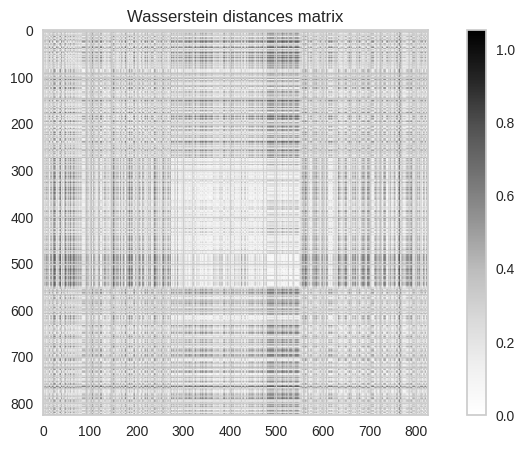

In [50]:
dgm = lower_star_img(Mw_matrix)
plt.figure(figsize=(10, 5))
#plt.subplot(121)
plt.imshow(Mw_matrix)
plt.colorbar()
plt.title("Wasserstein distances matrix")
#plt.subplot(122)

#dgm = lower_star_img(Mj_matrix)
#plt.imshow(Mj_matrix)
#plt.colorbar()
#plt.title("Jensen-Shannon matrix")
#plt.tight_layout()
#plt.show()

Text(0.5, 0, 'Dimension')

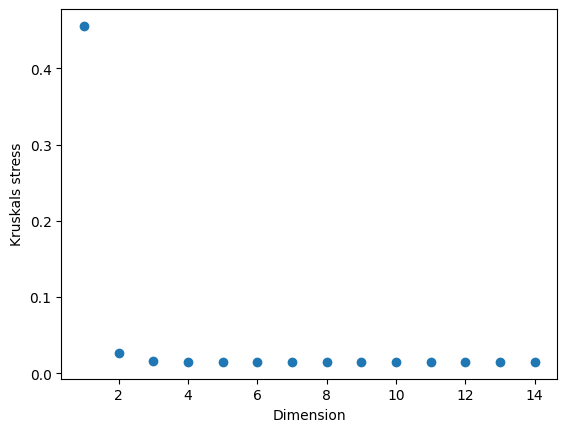

In [40]:
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import seaborn as sns
s,si=[],[]
stress1,i=1,1
while i<15:
    mds = MDS(n_components=i,dissimilarity='precomputed', random_state=0, normalized_stress='auto')
    # Get the embeddings
    X_transform = mds.fit_transform(Mw_matrix)
    ## Kruskal's stress (or stress formula 1)
    DE = euclidean_distances(X_transform)
    stress = 0.5 * np.sum((DE - Mw_matrix)**2)
    stress1=np.sqrt(stress / (0.5 * np.sum(Mw_matrix**2)))
    s.append(stress1)
    si.append(i)
    i=i+1
plt.scatter(si,s)
plt.ylabel('Kruskals stress')
plt.xlabel('Dimension')

In [41]:
mds = MDS(n_components=2,dissimilarity='precomputed',
          random_state=0, normalized_stress='auto')
# Get the embeddings
X_transform = mds.fit_transform(Mw_matrix)

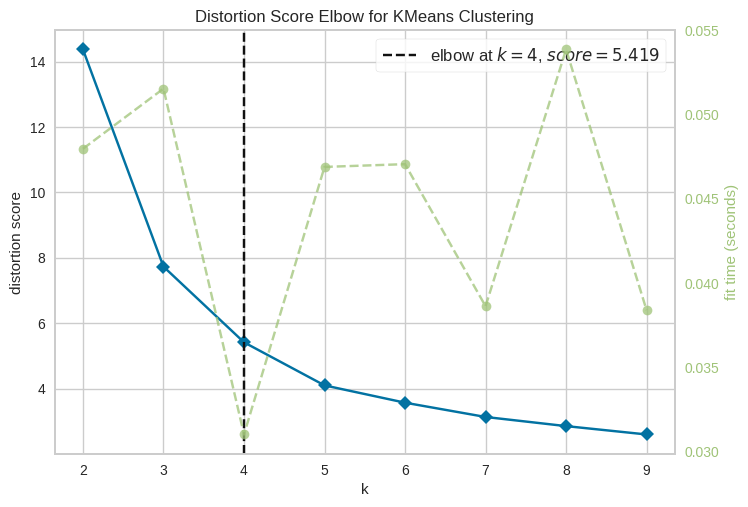

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42,n_init='auto')
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(X_transform)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

<Axes: >

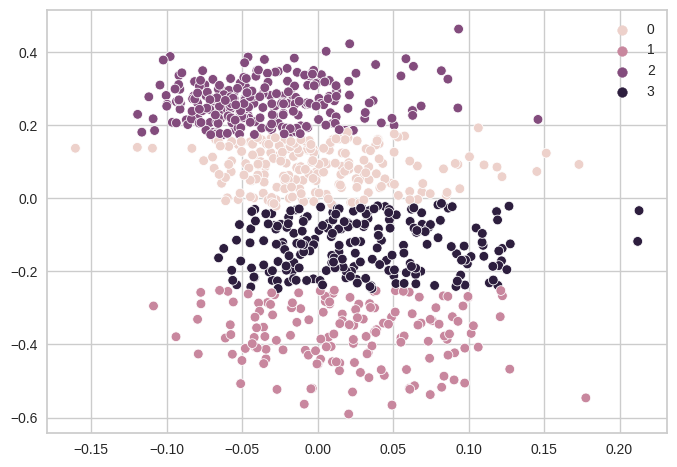

In [45]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

kmeans_model = KMeans(n_clusters = 4,n_init='auto')
kmeans_model.fit(X_transform)
sns.scatterplot(x=X_transform[:,0],y=X_transform[:,1],hue=kmeans_model.labels_)


In [46]:
adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

In [47]:
#evaluating clustering
rand_index = adjusted_rand_score(labels_true = adata.obs['Cell_Type'], labels_pred = adata.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.91
